**Mixture of experts (MoE)** refers to a machine learning technique where multiple expert networks (learners) are used to divide a problem space into homogeneous regions. (Wiki) </br>
**Multi-gate Mixture-of-Experts (MMoE)** - learns to model task relationships from data. </br>


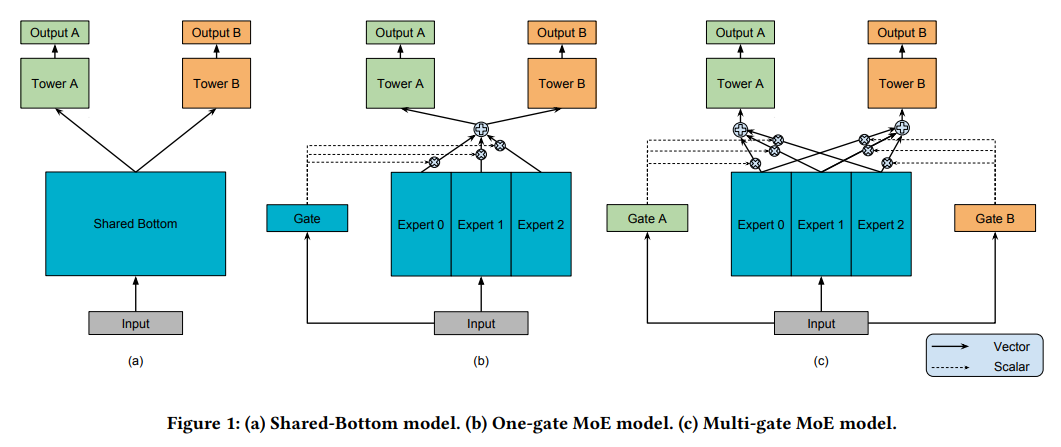

Image from: https://towardsdatascience.com/multi-task-learning-with-multi-gate-mixture-of-experts-b46efac3268

**Shared Bottom:** The model has a single base that is used for all tasks. </br>
**One-Gate MoE:** The model is able to learn different patterns in the data and focus on different things.  </br>
**MMoE:** The MMoE is similar to the MoE, but it has an individual gating network for each task, rather than a single one for the entire model.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec

In [5]:
# MMoe Model (From:https://github.com/drawbridge/keras-mmoe/blob/master/mmoe.py)
class MMoE(Layer):
    """
    Multi-gate Mixture-of-Experts model.
    """

    def __init__(self,
                 units,
                 num_experts,
                 num_tasks,
                 use_expert_bias=True,
                 use_gate_bias=True,
                 expert_activation='relu',
                 gate_activation='softmax',
                 expert_bias_initializer='zeros',
                 gate_bias_initializer='zeros',
                 expert_bias_regularizer=None,
                 gate_bias_regularizer=None,
                 expert_bias_constraint=None,
                 gate_bias_constraint=None,
                 expert_kernel_initializer='VarianceScaling',
                 gate_kernel_initializer='VarianceScaling',
                 expert_kernel_regularizer=None,
                 gate_kernel_regularizer=None,
                 expert_kernel_constraint=None,
                 gate_kernel_constraint=None,
                 activity_regularizer=None,
                 **kwargs):
        """
         Method for instantiating MMoE layer.

        :param units: Number of hidden units
        :param num_experts: Number of experts
        :param num_tasks: Number of tasks
        :param use_expert_bias: Boolean to indicate the usage of bias in the expert weights
        :param use_gate_bias: Boolean to indicate the usage of bias in the gate weights
        :param expert_activation: Activation function of the expert weights
        :param gate_activation: Activation function of the gate weights
        :param expert_bias_initializer: Initializer for the expert bias
        :param gate_bias_initializer: Initializer for the gate bias
        :param expert_bias_regularizer: Regularizer for the expert bias
        :param gate_bias_regularizer: Regularizer for the gate bias
        :param expert_bias_constraint: Constraint for the expert bias
        :param gate_bias_constraint: Constraint for the gate bias
        :param expert_kernel_initializer: Initializer for the expert weights
        :param gate_kernel_initializer: Initializer for the gate weights
        :param expert_kernel_regularizer: Regularizer for the expert weights
        :param gate_kernel_regularizer: Regularizer for the gate weights
        :param expert_kernel_constraint: Constraint for the expert weights
        :param gate_kernel_constraint: Constraint for the gate weights
        :param activity_regularizer: Regularizer for the activity
        :param kwargs: Additional keyword arguments for the Layer class
        """
        # Hidden nodes parameter
        self.units = units
        self.num_experts = num_experts
        self.num_tasks = num_tasks

        # Weight parameter
        self.expert_kernels = None
        self.gate_kernels = None
        self.expert_kernel_initializer = initializers.get(expert_kernel_initializer)
        self.gate_kernel_initializer = initializers.get(gate_kernel_initializer)
        self.expert_kernel_regularizer = regularizers.get(expert_kernel_regularizer)
        self.gate_kernel_regularizer = regularizers.get(gate_kernel_regularizer)
        self.expert_kernel_constraint = constraints.get(expert_kernel_constraint)
        self.gate_kernel_constraint = constraints.get(gate_kernel_constraint)

        # Activation parameter
        self.expert_activation = activations.get(expert_activation)
        self.gate_activation = activations.get(gate_activation)

        # Bias parameter
        self.expert_bias = None
        self.gate_bias = None
        self.use_expert_bias = use_expert_bias
        self.use_gate_bias = use_gate_bias
        self.expert_bias_initializer = initializers.get(expert_bias_initializer)
        self.gate_bias_initializer = initializers.get(gate_bias_initializer)
        self.expert_bias_regularizer = regularizers.get(expert_bias_regularizer)
        self.gate_bias_regularizer = regularizers.get(gate_bias_regularizer)
        self.expert_bias_constraint = constraints.get(expert_bias_constraint)
        self.gate_bias_constraint = constraints.get(gate_bias_constraint)

        # Activity parameter
        self.activity_regularizer = regularizers.get(activity_regularizer)

        # Keras parameter
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

        super(MMoE, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Method for creating the layer weights.

        :param input_shape: Keras tensor (future input to layer)
                            or list/tuple of Keras tensors to reference
                            for weight shape computations
        """
        assert input_shape is not None and len(input_shape) >= 2

        input_dimension = input_shape[-1]

        # Initialize expert weights (number of input features * number of units per expert * number of experts)
        self.expert_kernels = self.add_weight(
            name='expert_kernel',
            shape=(input_dimension, self.units, self.num_experts),
            initializer=self.expert_kernel_initializer,
            regularizer=self.expert_kernel_regularizer,
            constraint=self.expert_kernel_constraint,
        )

        # Initialize expert bias (number of units per expert * number of experts)
        if self.use_expert_bias:
            self.expert_bias = self.add_weight(
                name='expert_bias',
                shape=(self.units, self.num_experts),
                initializer=self.expert_bias_initializer,
                regularizer=self.expert_bias_regularizer,
                constraint=self.expert_bias_constraint,
            )

        # Initialize gate weights (number of input features * number of experts * number of tasks)
        self.gate_kernels = [self.add_weight(
            name='gate_kernel_task_{}'.format(i),
            shape=(input_dimension, self.num_experts),
            initializer=self.gate_kernel_initializer,
            regularizer=self.gate_kernel_regularizer,
            constraint=self.gate_kernel_constraint
        ) for i in range(self.num_tasks)]

        # Initialize gate bias (number of experts * number of tasks)
        if self.use_gate_bias:
            self.gate_bias = [self.add_weight(
                name='gate_bias_task_{}'.format(i),
                shape=(self.num_experts,),
                initializer=self.gate_bias_initializer,
                regularizer=self.gate_bias_regularizer,
                constraint=self.gate_bias_constraint
            ) for i in range(self.num_tasks)]

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dimension})

        super(MMoE, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """
        Method for the forward function of the layer.

        :param inputs: Input tensor
        :param kwargs: Additional keyword arguments for the base method
        :return: A tensor
        """
        gate_outputs = []
        final_outputs = []

        # f_{i}(x) = activation(W_{i} * x + b), where activation is ReLU according to the paper
        expert_outputs = tf.tensordot(a=inputs, b=self.expert_kernels, axes=1)
        # Add the bias term to the expert weights if necessary
        if self.use_expert_bias:
            expert_outputs = K.bias_add(x=expert_outputs, bias=self.expert_bias)
        expert_outputs = self.expert_activation(expert_outputs)

        # g^{k}(x) = activation(W_{gk} * x + b), where activation is softmax according to the paper
        for index, gate_kernel in enumerate(self.gate_kernels):
            gate_output = K.dot(x=inputs, y=gate_kernel)
            # Add the bias term to the gate weights if necessary
            if self.use_gate_bias:
                gate_output = K.bias_add(x=gate_output, bias=self.gate_bias[index])
            gate_output = self.gate_activation(gate_output)
            gate_outputs.append(gate_output)

        # f^{k}(x) = sum_{i=1}^{n}(g^{k}(x)_{i} * f_{i}(x))
        for gate_output in gate_outputs:
            expanded_gate_output = K.expand_dims(gate_output, axis=1)
            weighted_expert_output = expert_outputs * K.repeat_elements(expanded_gate_output, self.units, axis=1)
            final_outputs.append(K.sum(weighted_expert_output, axis=2))

        return final_outputs

    def compute_output_shape(self, input_shape):
        """
        Method for computing the output shape of the MMoE layer.

        :param input_shape: Shape tuple (tuple of integers)
        :return: List of input shape tuple where the size of the list is equal to the number of tasks
        """
        assert input_shape is not None and len(input_shape) >= 2

        output_shape = list(input_shape)
        output_shape[-1] = self.units
        output_shape = tuple(output_shape)

        return [output_shape for _ in range(self.num_tasks)]

    def get_config(self):
        """
        Method for returning the configuration of the MMoE layer.

        :return: Config dictionary
        """
        config = {
            'units': self.units,
            'num_experts': self.num_experts,
            'num_tasks': self.num_tasks,
            'use_expert_bias': self.use_expert_bias,
            'use_gate_bias': self.use_gate_bias,
            'expert_activation': activations.serialize(self.expert_activation),
            'gate_activation': activations.serialize(self.gate_activation),
            'expert_bias_initializer': initializers.serialize(self.expert_bias_initializer),
            'gate_bias_initializer': initializers.serialize(self.gate_bias_initializer),
            'expert_bias_regularizer': regularizers.serialize(self.expert_bias_regularizer),
            'gate_bias_regularizer': regularizers.serialize(self.gate_bias_regularizer),
            'expert_bias_constraint': constraints.serialize(self.expert_bias_constraint),
            'gate_bias_constraint': constraints.serialize(self.gate_bias_constraint),
            'expert_kernel_initializer': initializers.serialize(self.expert_kernel_initializer),
            'gate_kernel_initializer': initializers.serialize(self.gate_kernel_initializer),
            'expert_kernel_regularizer': regularizers.serialize(self.expert_kernel_regularizer),
            'gate_kernel_regularizer': regularizers.serialize(self.gate_kernel_regularizer),
            'expert_kernel_constraint': constraints.serialize(self.expert_kernel_constraint),
            'gate_kernel_constraint': constraints.serialize(self.gate_kernel_constraint),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer)
        }
        base_config = super(MMoE, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [46]:
"""
Multi-gate Mixture-of-Experts demo with census income data.

Copyright (c) 2018 Drawbridge, Inc
Licensed under the MIT License (see LICENSE for details)
Written by Peizhou Liao
"""

import random

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# from mmoe import MMoE

SEED = 1

# Fix numpy seed for reproducibility
np.random.seed(SEED)

# Fix random seed for reproducibility
random.seed(SEED)

# Fix TensorFlow graph-level seed for reproducibility
tf.random.set_seed(SEED)

def data_preparation():
    # Synthetic data parameters
    num_dimension = 100
    num_row = 12000
    c = 0.3
    rho = 0.8
    m = 5

    # Initialize vectors u1, u2, w1, and w2 according to the paper
    mu1 = np.random.normal(size=num_dimension)
    mu1 = (mu1 - np.mean(mu1)) / (np.std(mu1) * np.sqrt(num_dimension))
    mu2 = np.random.normal(size=num_dimension)
    mu2 -= mu2.dot(mu1) * mu1
    mu2 /= np.linalg.norm(mu2)
    w1 = c * mu1
    w2 = c * (rho * mu1 + np.sqrt(1. - rho ** 2) * mu2)

    # Feature and label generation
    alpha = np.random.normal(size=m)
    beta = np.random.normal(size=m)
    y0 = []
    y1 = []
    X = []

    for i in range(num_row):
        x = np.random.normal(size=num_dimension)
        X.append(x)
        num1 = w1.dot(x)
        num2 = w2.dot(x)
        comp1, comp2 = 0.0, 0.0

        for j in range(m):
            comp1 += np.sin(alpha[j] * num1 + beta[j])
            comp2 += np.sin(alpha[j] * num2 + beta[j])

        y0.append(num1 + comp1 + np.random.normal(scale=0.1, size=1))
        y1.append(num2 + comp2 + np.random.normal(scale=0.1, size=1))

    y0 = np.array(y0)
    y1 = np.array(y1)

    X = np.array(X)
    data = pd.DataFrame(
        data=X,
        index=range(X.shape[0]),
        columns=['x{}'.format(it) for it in range(X.shape[1])]
    )

    train_data = data.iloc[0:10000]
    train_label = [y0[0:10000], y1[0:10000]]
    validation_data = data.iloc[10000:11000]
    validation_label = [y0[10000:11000], y1[10000:11000]]
    test_data = data.iloc[11000:]
    test_label = [y0[11000:], y1[11000:]]

    return train_data, train_label, validation_data, validation_label, test_data, test_label

In [47]:
# Load the data
train_data, train_label, validation_data, validation_label, test_data, test_label = data_preparation()
num_features = train_data.shape[1]

print('Training data shape = {}'.format(train_data.shape))
print('Validation data shape = {}'.format(validation_data.shape))
print('Test data shape = {}'.format(test_data.shape))

# Set up the input layer
input_layer = Input(shape=(num_features,))

# Set up MMoE layer
mmoe_layers = MMoE(
    units=16,
    num_experts=8,
    num_tasks=2
)(input_layer)

output_layers = []

output_info = ['y0', 'y1']

# Build tower layer from MMoE layer
for index, task_layer in enumerate(mmoe_layers):
    tower_layer = Dense(
        units=8,
        activation='relu',
        kernel_initializer=VarianceScaling())(task_layer)
    output_layer = Dense(
        units=1,
        name=output_info[index],
        activation='linear',
        kernel_initializer=VarianceScaling())(tower_layer)
    output_layers.append(output_layer)

# Compile model
model = Model(inputs=[input_layer], outputs=output_layers)
learning_rates = [1e-4, 1e-3, 1e-2]
adam_optimizer = Adam(lr=learning_rates[0])
model.compile(
    loss={'y0': 'mean_squared_error', 'y1': 'mean_squared_error'},
    optimizer=adam_optimizer,
    metrics=[metrics.mae]
)

# Print out model architecture summary
model.summary()



Training data shape = (10000, 100)
Validation data shape = (1000, 100)
Test data shape = (1000, 100)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 m_mo_e_4 (MMoE)                [(None, 16),         14544       ['input_5[0][0]']                
                                 (None, 16)]                                                      
                                                                                                  
 dense_8 (Dense)                (None, 8)            136         ['m_mo_e_4[0][0]']               
                                                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
#train_data1 = np.stack(train_data, axis=0) 

In [48]:
# Train the model
model.fit(
    x=train_data,
    y=train_label,
    validation_data=(validation_data, validation_label),
    epochs=100
)

Epoch 1/100
313/313 [==============================] - 3s 5ms/step - loss: 12.9591 - y0_loss: 6.7883 - y1_loss: 6.1708 - y0_mean_absolute_error: 2.5392 - y1_mean_absolute_error: 2.4167 - val_loss: 11.5456 - val_y0_loss: 6.2080 - val_y1_loss: 5.3376 - val_y0_mean_absolute_error: 2.4244 - val_y1_mean_absolute_error: 2.2387
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 9.8250 - y0_loss: 5.5522 - y1_loss: 4.2728 - y0_mean_absolute_error: 2.2851 - y1_mean_absolute_error: 1.9890 - val_loss: 7.8688 - val_y0_loss: 4.7283 - val_y1_loss: 3.1405 - val_y0_mean_absolute_error: 2.1034 - val_y1_mean_absolute_error: 1.6866
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 5.7471 - y0_loss: 3.7576 - y1_loss: 1.9895 - y0_mean_absolute_error: 1.8562 - y1_mean_absolute_error: 1.2990 - val_loss: 3.8417 - val_y0_loss: 2.7611 - val_y1_loss: 1.0806 - val_y0_mean_absolute_error: 1.5784 - val_y1_mean_absolute_error: 0.9226
Epoch 4/100
313/313 [==============